In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn import metrics
from sklearn.manifold import TSNE
import scipy.stats as st
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

model_path = '/home/tstrebel/repos/umich-mads-capstone-project/tstrebe2/rnsa/models/rnsa-densenet.ckpt'
img_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images/'
img_features_path = '/home/tstrebel/assets/rnsa-pneumonia/rnsa-img-features.csv'
patient_data_path = '/home/tstrebel/repos/umich-mads-capstone-project/assets/rnsa-patient-details.csv'
all_labels_path = '/home/tstrebel/assets/rnsa-pneumonia/stage_2_train_labels.csv.zip'

In [2]:
df = pd.read_csv(img_features_path, index_col='index')

df_train_val = df[df.split.isin(['train', 'test'])]
df_test = df[df.split == 'test']

del df

_ = gc.collect()

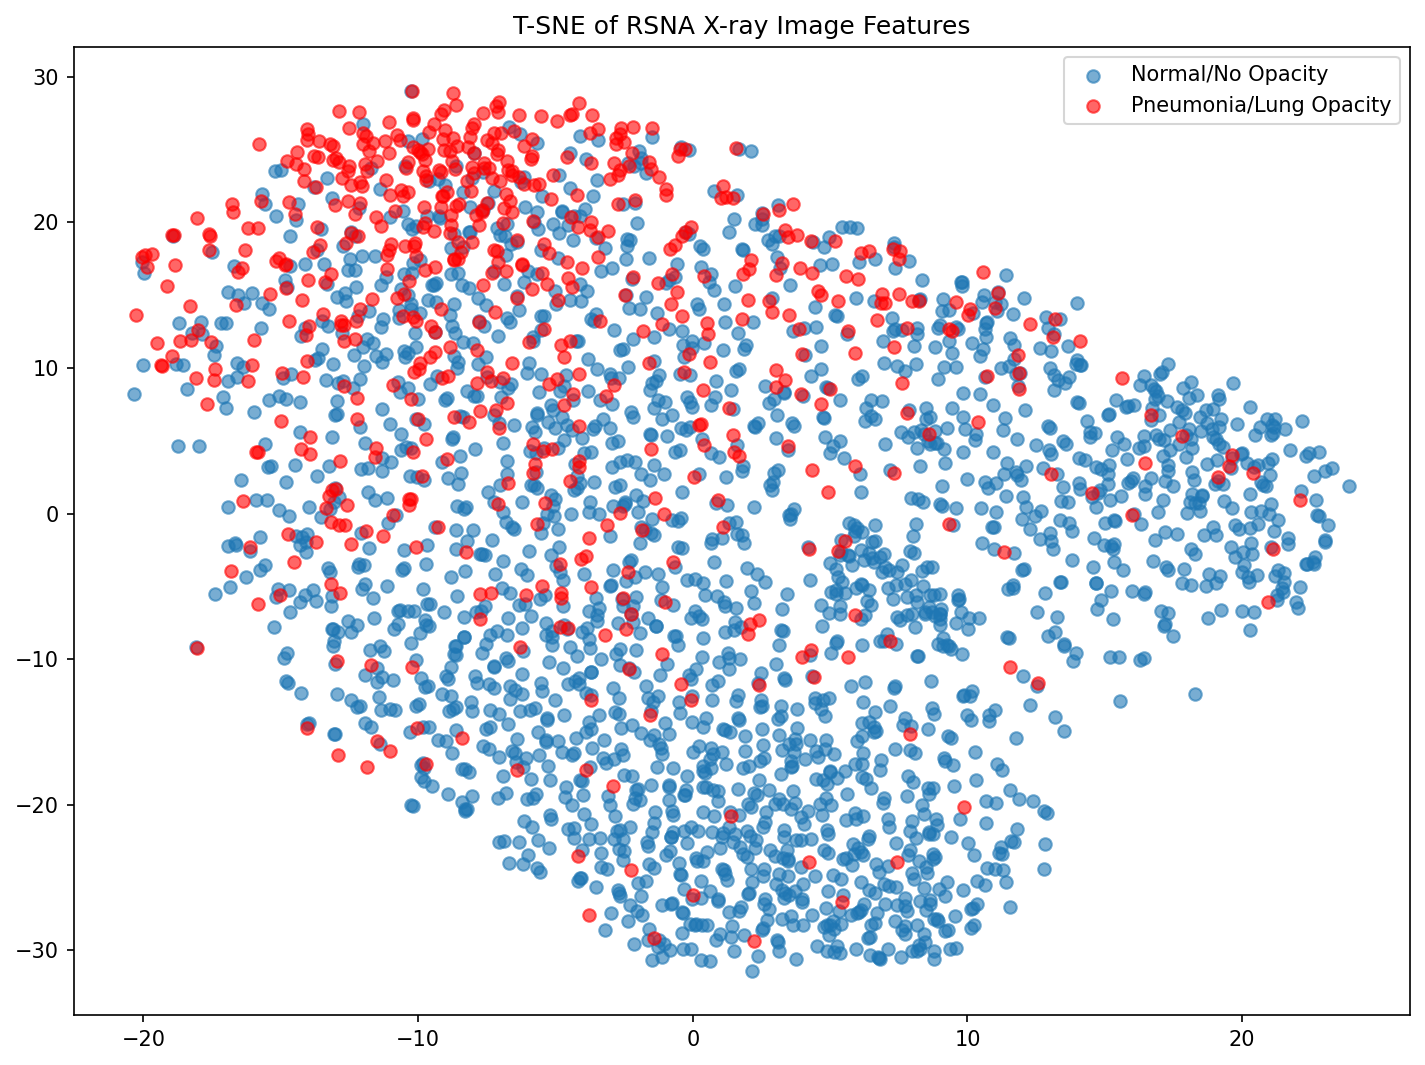

In [13]:
def plot_tsne(save_path=None):
    targets = df_test.iloc[:, -2]

    tsne = TSNE(n_components=2, 
                perplexity=50,
                early_exaggeration=50, 
                learning_rate=10, 
                n_jobs=-1
               ).fit_transform(df_test.iloc[:, 1:-2])

    ix_0 = np.where(targets == 0)[0]
    ix_1 = np.where(targets == 1)[0]

    figsize = np.array([6.4, 4.8]) * 1.5

    _ = plt.figure(dpi=150, figsize=figsize)
    plt.scatter(tsne[ix_0, 0], tsne[ix_0, 1], alpha=.6, label='Normal/No Opacity')
    plt.scatter(tsne[ix_1, 0], tsne[ix_1, 1], alpha=.6, color='red', label='Pneumonia/Lung Opacity')
    plt.title('T-SNE of RSNA X-ray Image Features')
    plt.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png', orientation='landscape')
    plt.show()
    
plot_tsne(save_path='/home/tstrebel/repos/umich-mads-capstone-project/figures/tsne-rnsa-image-features.png')

In [2]:
THRESH = 0.3948
df_patients = pd.read_csv(patient_data_path, index_col='index')
df_patients['densenet_prediction'] = (df_patients['densenet_predict_proba'] >= THRESH).astype(int)
df_patients['age_group'] = pd.cut(df_patients.patient_age, 
                                  [0, 1, 5, 12, 18, 44, 64, 79, np.inf], 
                                  labels=['Infant 1 year-old', 'preschool (2-5)', 'Child (6-12)', 'Adolescent (13-18)', 'Adult (19-44)', 'Middle age (45-64)', 'Aged (65-79)', 'Aged 80+']
                                 )
df_patients['view_position'] = df_patients['view_position'].map({'AP':'Anterior/Posterior', 'PA':'Posterior/Anterior'})
df_patients

,patient_id,patient_age,patient_sex,view_position,class,target,split,densenet_predict_proba,densenet_prediction,age_group
index,,,,,,,,,,
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,Posterior/Anterior,No Lung Opacity / Not Normal,0,train,0.028890,0,Middle age (45-64)
1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,Anterior/Posterior,Normal,0,train,0.002505,0,Adult (19-44)
2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,Anterior/Posterior,Lung Opacity,1,train,0.226189,0,Adult (19-44)
3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,Anterior/Posterior,Lung Opacity,1,train,0.967209,1,Adult (19-44)
4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,Posterior/Anterior,Lung Opacity,1,train,0.067874,0,Middle age (45-64)
...,...,...,...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,46,M,Anterior/Posterior,Lung Opacity,1,train,0.931316,1,Middle age (45-64)
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,31,M,Posterior/Anterior,Normal,0,val,0.000546,0,Adult (19-44)
26681,fffc95b5-605b-4226-80ab-62caec682b22,30,F,Anterior/Posterior,No Lung Opacity / Not Normal,0,test,0.692472,1,Adult (19-44)


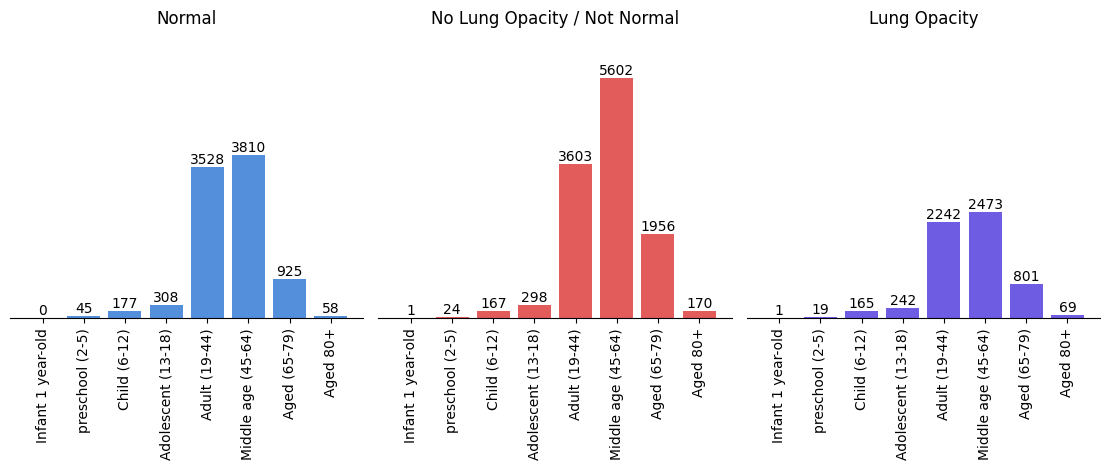

In [20]:
from matplotlib import cm

def plot_feature_and_classes(data, feature, figsize, rotation=None, save_path=None):
    classes = ['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity']
    colors = ['#1b6ad1', '#d92525', '#3d25d9']
    
    fig, axs = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=figsize, sharex=True, sharey=True)
    
    for class_, color, ax in zip(classes, colors, axs):

        plot_data = data[data['class']==class_][feature].value_counts().sort_index()
        x, y = plot_data.index.astype(str).tolist(), plot_data.values

        p1 = ax.bar(x, y, color=color, alpha=.75)
        ax.bar_label(p1)
        ax.set_title(class_, pad=30)

        if rotation:
            ticks_loc = ax.get_xticks()
            ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
            
        ax.get_yaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
            
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png', orientation='landscape')
        
    plt.show()

save_path='/home/tstrebel/repos/umich-mads-capstone-project/figures/age-groups.png'
figsize=np.array([6.4*1.75, 4.8])
plot_feature_and_classes(df_patients, rotation=90, figsize=figsize, feature='age_group', save_path=save_path)

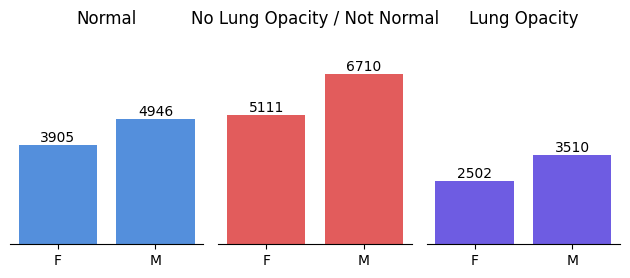

In [21]:
save_path='/home/tstrebel/repos/umich-mads-capstone-project/figures/patient-sex.png'
figsize=np.array([6.4, 4.8*.6])
plot_feature_and_classes(df_patients, feature='patient_sex', figsize=figsize, save_path=save_path)

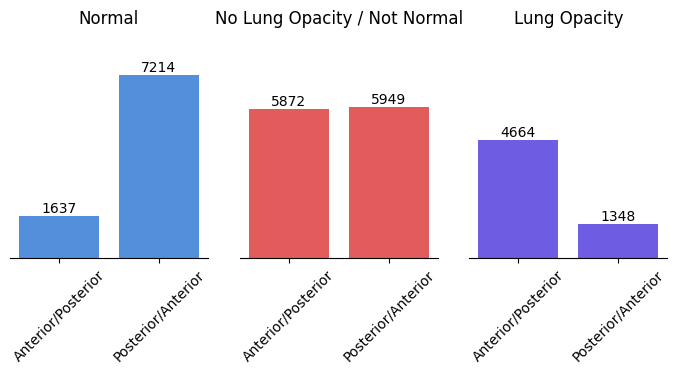

In [22]:
save_path='/home/tstrebel/repos/umich-mads-capstone-project/figures/view-position.png'
figsize=np.array([6.4*1.1, 4.8*.8])
plot_feature_and_classes(df_patients, feature='view_position', rotation=45, figsize=figsize, save_path=save_path)

In [41]:
pd.set_option('display.precision', 3)

df_test = df_patients[df_patients['split'] == 'test']

def get_metrics_by_group(data, group):
    n = data[group].value_counts().rename('n-patients')
    n_neg = data[data.target == 0][group].value_counts().rename('n-negative')
    n_pos = data[data.target == 1][group].value_counts().rename('n-positive')
    n = n.to_frame().join([n_neg, n_pos])
    
    results = []
    
    def get_metrics(grp, metric_fn):
        if len(grp) > 0:
            return metric_fn(grp['target'], grp['densenet_prediction'])
        else:
            return 0
    
    for metric_name, metric_fn in [('Precision', partial(metrics.precision_score, zero_division=0)), 
                                   ('Recall', metrics.recall_score), 
                                   ('F1', metrics.f1_score), 
                                   ('Accuracy', metrics.accuracy_score)]:
        metric_result = (data.groupby(group)
                  .apply(get_metrics, metric_fn)).rename(metric_name)
        results.append(metric_result)
        
    def get_average_precision_score(grp):
        if len(grp) > 0:
            return metrics.average_precision_score(grp['target'], grp['densenet_predict_proba'])
        else:
            return 0
        
    avg_precision = (data.groupby(group)
              .apply(get_average_precision_score).rename('Average Precision'))
    results.append(avg_precision)
    
    return n.join(results).sort_index()

get_metrics_by_group(df_test, group='patient_sex')

,n-patients,n-negative,n-positive,Precision,Recall,F1,Accuracy,Average Precision
F,1148,906,242,0.594,0.624,0.609,0.831,0.664
M,1520,1161,359,0.622,0.591,0.606,0.818,0.648


In [42]:
get_metrics_by_group(df_test, group='view_position')

,n-patients,n-negative,n-positive,Precision,Recall,F1,Accuracy,Average Precision
Anterior/Posterior,1242,784,458,0.626,0.694,0.658,0.734,0.704
Posterior/Anterior,1426,1283,143,0.517,0.315,0.391,0.902,0.443


In [43]:
get_metrics_by_group(df_test, group='age_group')

,n-patients,n-negative,n-positive,Precision,Recall,F1,Accuracy,Average Precision
Infant 1 year-old,0,0,0,0.000,0.000,0.000,0.000,0.000
preschool (2-5),8,6,2,0.000,0.000,0.000,0.750,0.833
Child (6-12),43,28,15,0.778,0.933,0.848,0.884,0.876
Adolescent (13-18),82,55,27,0.704,0.704,0.704,0.805,0.738
Adult (19-44),942,730,212,0.604,0.632,0.618,0.824,0.668
Middle age (45-64),1221,962,259,0.621,0.595,0.607,0.837,0.663
Aged (65-79),351,273,78,0.521,0.487,0.503,0.786,0.510
Aged 80+,21,13,8,0.571,0.500,0.533,0.667,0.737


In [61]:
def get_f1_adjusted_metrics_by_group(data, group):
    n = data[group].value_counts().rename('n-patients')
    n_neg = data[data.target == 0][group].value_counts().rename('n-negative')
    n_pos = data[data.target == 1][group].value_counts().rename('n-positive')
    n = n.to_frame().join([n_neg, n_pos])
    
    results = []
    
    def get_f1_adj_trhes(grp):
        if len(grp) > 0:
            precision, recall, pr_thresholds = metrics.precision_recall_curve(grp['target'], grp['densenet_predict_proba'])
            f1_scores = (2 * precision * recall) / ((precision + recall) + 1e-8)

            ix = np.argmax(f1_scores)
            best_thresh = pr_thresholds[ix]
            return best_thresh
        else:
            return 0
        
    adj_thresh = data.groupby(group).apply(get_f1_adj_trhes).rename('Adjusted Threshold')
    adj_thresh_dict = adj_thresh.to_dict()
    
    def get_metrics(grp, metric_fn):
        if len(grp) > 0:
            best_thresh = adj_thresh_dict[grp.name]
            
            adj_prediction = (grp['densenet_predict_proba'] >= best_thresh).astype(int)
            return metric_fn(grp['target'], adj_prediction)
        else:
            return 0
    
    for metric_name, metric_fn in [('Precision', partial(metrics.precision_score, zero_division=0)), 
                                   ('Recall', metrics.recall_score), 
                                   ('F1', metrics.f1_score),
                                   ('Accuracy', metrics.accuracy_score)]:
        metric_result = (data.groupby(group)
                  .apply(get_metrics, metric_fn)).rename(metric_name)
        results.append(metric_result)
        
    def get_average_precision_score(grp):
        if len(grp) > 0:
            
            return metrics.average_precision_score(grp['target'], grp['densenet_predict_proba'])
        else:
            return 0
        
    avg_precision = (data.groupby(group)
              .apply(get_average_precision_score).rename('Average Precision'))
    results.append(avg_precision)
    results.append(adj_thresh)
    
    return n.join(results).sort_index()

In [60]:
get_metrics_by_group(df_test, group='age_group')

,n-patients,n-negative,n-positive,Precision,Recall,F1,Accuracy,Average Precision
Infant 1 year-old,0,0,0,0.000,0.000,0.000,0.000,0.000
preschool (2-5),8,6,2,0.000,0.000,0.000,0.750,0.833
Child (6-12),43,28,15,0.778,0.933,0.848,0.884,0.876
Adolescent (13-18),82,55,27,0.704,0.704,0.704,0.805,0.738
Adult (19-44),942,730,212,0.604,0.632,0.618,0.824,0.668
Middle age (45-64),1221,962,259,0.621,0.595,0.607,0.837,0.663
Aged (65-79),351,273,78,0.521,0.487,0.503,0.786,0.510
Aged 80+,21,13,8,0.571,0.500,0.533,0.667,0.737


In [62]:
get_f1_adjusted_metrics_by_group(df_test, group='age_group')

,n-patients,n-negative,n-positive,Precision,Recall,F1,Accuracy,Average Precision,Adjusted Threshold
Infant 1 year-old,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
preschool (2-5),8,6,2,0.667,1.000,0.800,0.875,0.833,0.082
Child (6-12),43,28,15,0.778,0.933,0.848,0.884,0.876,0.422
Adolescent (13-18),82,55,27,0.667,0.815,0.733,0.805,0.738,0.213
Adult (19-44),942,730,212,0.593,0.708,0.645,0.825,0.668,0.336
Middle age (45-64),1221,962,259,0.592,0.660,0.624,0.831,0.663,0.336
Aged (65-79),351,273,78,0.478,0.705,0.570,0.764,0.510,0.248
Aged 80+,21,13,8,0.615,1.000,0.762,0.762,0.737,0.199


In [80]:
def print_metrics(data, adjust_by=None):
    n = len(data)
    n_neg = len(data[data.target == 0])
    n_pos = len(data[data.target == 1])
    
    def get_f1_adj_trhes(grp):
        if len(grp) > 0:
            precision, recall, pr_thresholds = metrics.precision_recall_curve(grp['target'], grp['densenet_predict_proba'])
            f1_scores = (2 * precision * recall) / ((precision + recall) + 1e-8)

            ix = np.argmax(f1_scores)
            best_thresh = pr_thresholds[ix]
            return best_thresh
        else:
            return 0
    
    if adjust_by:
        adj_thresh_dict = (data
                           .groupby(adjust_by)
                           .apply(get_f1_adj_trhes)
                           .rename('Adjusted Threshold')
                           .to_dict())
        adj_thresh = data[adjust_by].astype(str).map(adj_thresh_dict)
        preds = (data['densenet_predict_proba'] >= adj_thresh).astype(int)
    else:
        preds = data['densenet_prediction']
        
    targets = data['target']
    precision = metrics.precision_score(targets, preds)
    recall = metrics.recall_score(targets, preds)
    f1 = metrics.f1_score(targets, preds)
    accuracy = metrics.accuracy_score(targets, preds)
    
    print('N Samples:\t{:,}'.format(n))
    print('N Negative:\t{:,}'.format(n_neg))
    print('N Positive:\t{:,}'.format(n_pos))
    print()
    print('Adj Precision:\t{:.3f}'.format(precision))
    print('Adj Recall:\t{:.3f}'.format(recall))
    print('Adj f1:\t\t{:.3f}'.format(f1))
    print('Adj Accuracy:\t{:.3f}'.format(accuracy))

In [79]:
print_metrics(df_test)

N Samples:	2,668
N Negative:	2,067
N Positive:	601

Adj Precision:	0.610
Adj Recall:	0.604
Adj f1:		0.607
Adj Accuracy:	0.824


In [81]:
print_metrics(df_test, adjust_by='age_group')

N Samples:	2,668
N Negative:	2,067
N Positive:	601

Adj Precision:	0.583
Adj Recall:	0.702
Adj f1:		0.637
Adj Accuracy:	0.820


In [7]:
import visuals
import models
import torch
import data

df_all = pd.read_csv(all_labels_path).rename({'patientId':'patient_id', 'Target':'target'}, axis=1)
df_all.head()

,patient_id,x,y,width,height,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.Densenet121GradCam()
state_dict = torch.load(model_path, map_location=device)['state_dict']
_ = model.load_state_dict(state_dict)
model = model.to(device)

dataset = data.get_dataset(img_dir, df_test)

In [23]:
# import torchvision

# torchvision.models.resnet.ResNet??

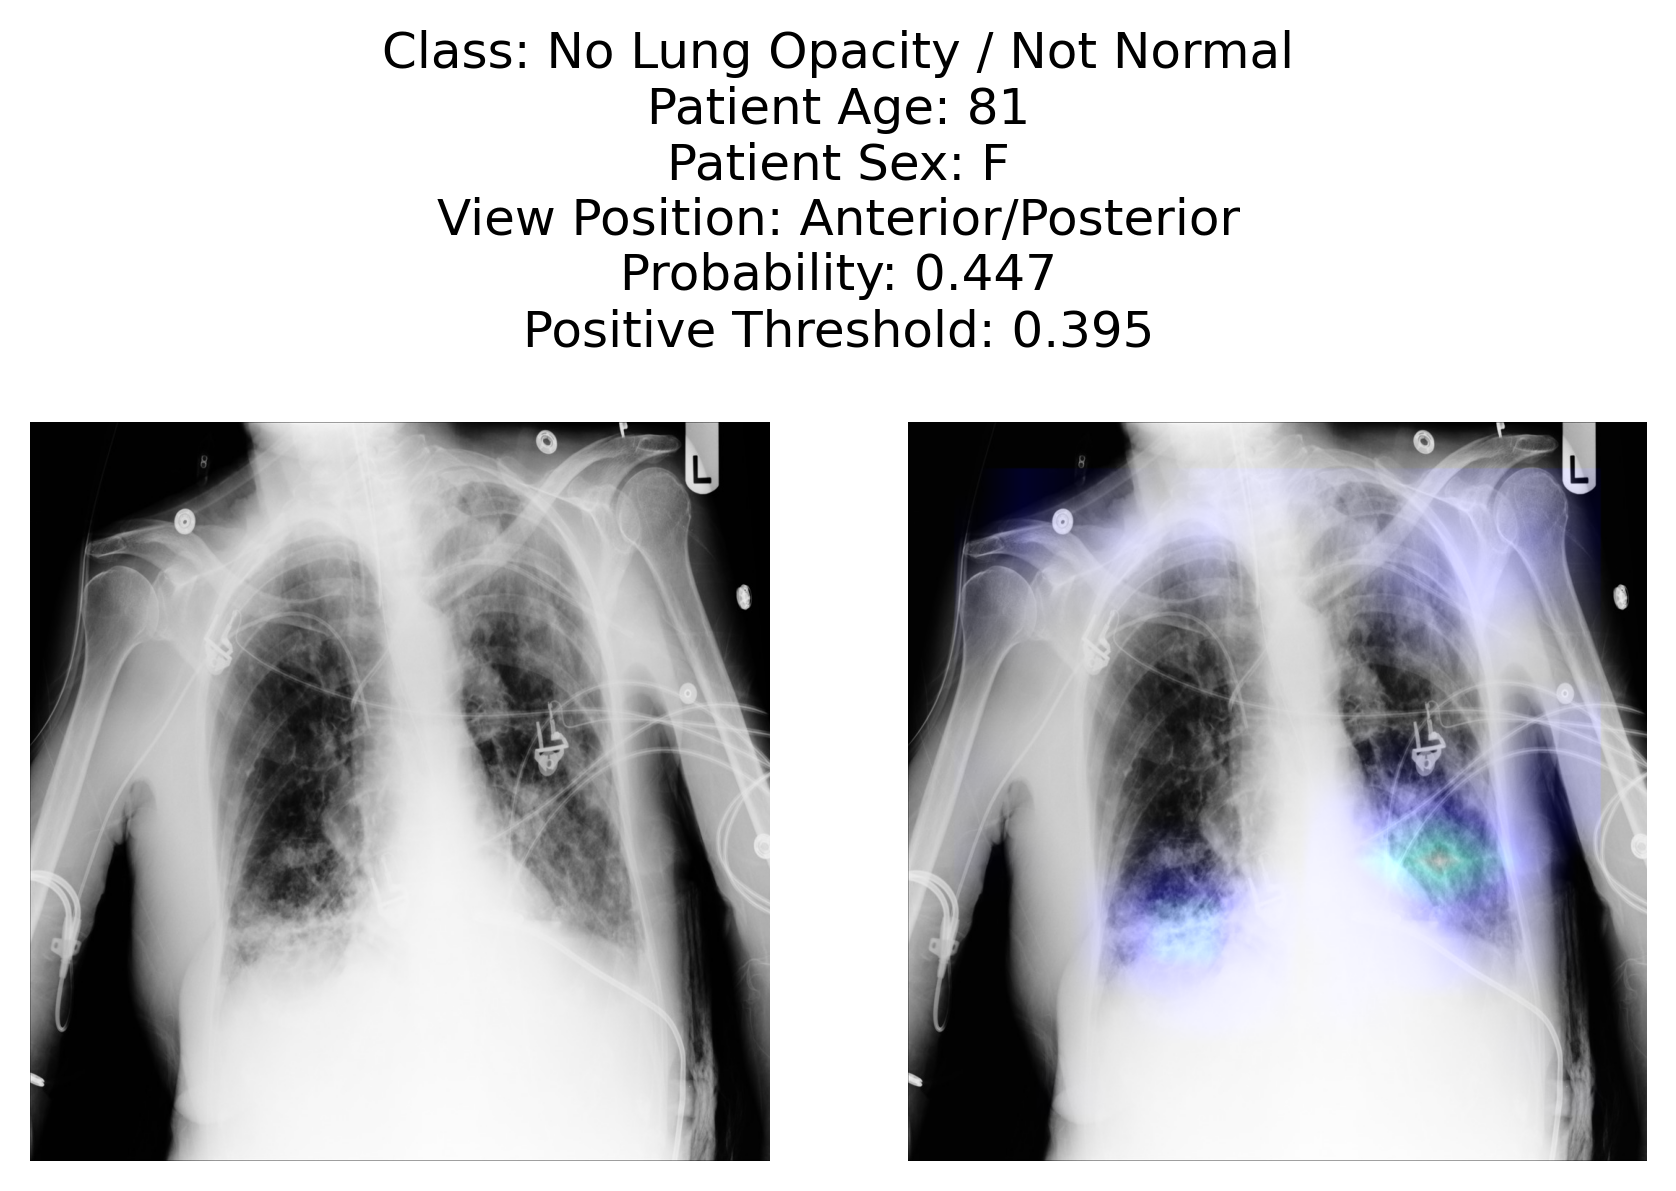

In [31]:
patient = df_test[(df_test.patient_age >= 80) & (df_test.target == 0) & (df_test.densenet_prediction == 1)].sample(1).iloc[0]
threshold=0.3948
idx = np.where(df_test.patient_id==patient.patient_id)[0][0]
inputs, target = dataset[idx]

inputs = inputs.unsqueeze(dim=0).to(device)
target = target.to(device)
    
fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300)
visuals.show_gradcam(img_dir, model, patient, inputs, target, df_all, ax1, ax2, threshold=threshold)

ax1.axis('off')
ax2.axis('off')
fig.suptitle('Class: {}\nPatient Age: {}\nPatient Sex: {}\nView Position: {}\nProbability: {:.3f}\nPositive Threshold: {:.3f}'
             .format(patient['class'], 
                     patient.patient_age, 
                     patient.patient_sex,
                     patient.view_position,
                     patient.densenet_predict_proba,
                     THRESH,))
fig.tight_layout()
plt.show()